In [1]:
import os
import pickle 
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from glob import glob

sns.set()

sys.path.append('../')
from modules.critical_difference_diagram import draw_cd_diagram

%load_ext autoreload
%autoreload 2

In [2]:
# config
root = '../../results/'
exps = ['baseline']
subsets = ['subset_100.0']

In [3]:
def maybe_rename(dataset):
    if dataset == 'anomaly_new':
        dataset = 'Anomaly'
    if dataset == 'NonInvasiveFetalECGThorax1':
        dataset = 'NonInvasiveFetalECG'
    return dataset

In [4]:
def get_acc_files(root, exps, subsets, baseline=False):
    files = []
    for exp in exps:
        for subset in subsets:
            if baseline:
                files.extend(glob(root + '/' + exp + '/**/**_report.pickle'))
            files.extend(glob(root + '/' + exp + '/**/**/' + subset + '/**_report.pickle'))
    return files

# get pickle data
def get_acc_dict(files):
    res_dict = {}
    for fname in files:
        dataset = fname.split('/')[5]
        dataset = maybe_rename(dataset)
        name = 'complete'
        if len(fname.split('/')) > 7:
            name = fname.split('/')[7]
        if dataset not in list(res_dict):
            res_dict[dataset] = {}
        with open(fname, 'rb') as f:
            res_dict[dataset][name] = pickle.load(f)
    return res_dict


def create_acc_table(res_dict, acc=False):
    max_len = max([len(d) for d in res_dict])
    acc_str = ' ' * max_len
    for dset in sorted(res_dict['Crop']):
        acc_str = acc_str + ' & ' + dset
    acc_str += ' \\\\'
    acc_str = acc_str + ' ' * max_len
    for dset in sorted(res_dict['Crop']):
        acc_str = acc_str + ' & macro  & micro '
        if acc:
            acc_str = acc_str + ' &  acc  '
    acc_str += ' \\\\'
    factor = 2 if not acc else 3
    averages = np.zeros(factor * len(list(res_dict['Crop'])))
    for dataset in sorted(res_dict):
        acc_str = acc_str + dataset + ' ' * (max_len - len(dataset))
        for idx, dset in enumerate(sorted(res_dict[dataset])):
            macro = res_dict[dataset][dset]['macro avg']['f1-score']
            micro = res_dict[dataset][dset]['weighted avg']['f1-score']
            acc_str = acc_str  + ' & '+ '{:.4f}'.format(macro) + ' & '+ '{:.4f}'.format(micro)
            averages[idx * factor] += macro
            averages[idx * factor + 1] += micro
            if acc:
                accuracy = res_dict[dataset][dset]['accuracy']
                averages[idx * factor + 2] += accuracy
                acc_str = acc_str  + ' & '+ '{:.4f}'.format(accuracy)
        acc_str += ' \\\\'
    averages /= len(list(res_dict))
    acc_str = acc_str + 'Average' + ' ' * (max_len - len('Average'))
    for avg in averages:
        acc_str = acc_str  + ' & '+ '{:.4f}'.format(avg)
    acc_str += ' \\\\'
    print(acc_str.replace('\\\\', '\\\\\n'))

In [5]:
# baseline accuracy and subset acc
acc_files = get_acc_files(root, exps, subsets, baseline=True)
res_dict = get_acc_dict(acc_files)
create_acc_table(res_dict, acc=True)

                         & complete & subset_100.0 \\
                         & macro  & micro  &  acc   & macro  & micro  &  acc   \\
Anomaly                  & 0.9769 & 0.9871 & 0.9872 & 0.9699 & 0.9797 & 0.9800 \\
AsphaltPavementType      & 0.9169 & 0.9244 & 0.9242 & 0.8905 & 0.8991 & 0.9000 \\
AsphaltRegularity        & 1.0000 & 1.0000 & 1.0000 & 1.0000 & 1.0000 & 1.0000 \\
CharacterTrajectories    & 0.9940 & 0.9944 & 0.9944 & 1.0000 & 1.0000 & 1.0000 \\
Crop                     & 0.7189 & 0.7189 & 0.7281 & 0.7058 & 0.7228 & 0.7400 \\
ECG5000                  & 0.5611 & 0.9352 & 0.9436 & 0.6045 & 0.9412 & 0.9500 \\
ElectricDevices          & 0.6286 & 0.6935 & 0.7056 & 0.6709 & 0.7602 & 0.7900 \\
FaceDetection            & 0.6634 & 0.6634 & 0.6637 & 0.6779 & 0.6790 & 0.6800 \\
FordA                    & 0.9492 & 0.9492 & 0.9492 & 0.9294 & 0.9299 & 0.9300 \\
HandOutlines             & 0.9464 & 0.9510 & 0.9514 & 0.9399 & 0.9493 & 0.9500 \\
MedicalImages            & 0.7227 & 0.7461 &

In [6]:
def get_files(root, exps, subsets, contains=''):
    files = []
    for exp in exps:
        for subset in subsets:
            files.extend(glob(root + '/' + exp + '/**/**/' + subset + '/**/**' + contains + '**'))
    return files

# get pickle data
def get_res_dict(files):
    res_dict = {}
    for fname in files:
        dataset = fname.split('/')[-5]
        dataset = maybe_rename(dataset)
        with open(fname, 'rb') as f:
            res_dict[dataset] = pickle.load(f)
    return res_dict

In [7]:
# create critical diagram compatible dataframe
def create_critical_auc(root, res_dict):
    for del_ins in res_dict[list(res_dict)[0]]['summary']:
        for metric in res_dict[list(res_dict)[0]]['summary'][del_ins]:
            data = []
            print(del_ins, metric)
            for dataset in res_dict:
                part_dict = res_dict[dataset]['summary'][del_ins][metric]
                for method, score in part_dict.items():
                    score = 1 - score if del_ins == 'del' else score
                    data.append([method, dataset, score])
            frame = pd.DataFrame(data, columns=['classifier_name', 'dataset_name', 'accuracy'])
            fname = os.path.join(root, 'paper_figures', 'CDD_AUC_' + del_ins + '_' + metric.replace('/', ' ') + '.png')
            draw_cd_diagram(df_perf=frame, title=metric, labels=True, save_path=fname)

def create_auc_table(res_dict):
    max_len = max([len(d) for d in res_dict])
    auc_str = ' ' * max_len
    for method in sorted(res_dict['Crop']['summary']['del']['accuracy']):
        auc_str = auc_str + ' & ' + method
    auc_str += ' \\\\'
    auc_str = auc_str + ' ' * max_len
    for method in sorted(res_dict['Crop']['summary']['del']['accuracy']):
        auc_str = auc_str + ' & del    & ins   '
    auc_str += ' \\\\'
    averages = np.zeros(2 * len(list(res_dict['Crop']['summary']['del']['accuracy'])))
    for dataset in sorted(res_dict):
        auc_str = auc_str + dataset + ' ' * (max_len - len(dataset))
        for idx, method in enumerate(sorted(res_dict[dataset]['summary']['del']['accuracy'])):
            del_value = res_dict[dataset]['summary']['del']['accuracy'][method]
            ins_value = res_dict[dataset]['summary']['ins']['accuracy'][method]
            auc_str = auc_str  + ' & '+ '{:.4f}'.format(del_value)
            auc_str = auc_str  + ' & '+ '{:.4f}'.format(ins_value)
            averages[2 * idx] += del_value
            averages[2 * idx + 1] += ins_value
        auc_str += ' \\\\'
    averages /= len(list(res_dict))
    auc_str = auc_str + 'Average' + ' ' * (max_len - len('Average'))
    for avg in averages:
        auc_str = auc_str  + ' & '+ '{:.4f}'.format(avg)
    auc_str += ' \\\\'
    print(auc_str.replace('\\\\', '\\\\\n'))

del accuracy
FeatureAblation         0.0
GuidedBackprop          2.0
IntegratedGradients     1.0
Lime                    0.0
Occlusion               1.0
Timereise              13.0
dtype: float64


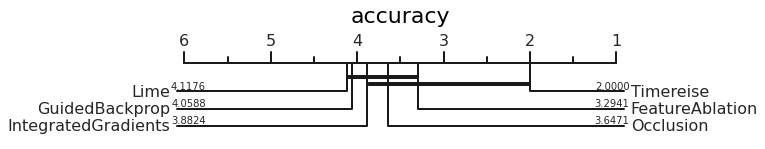

del macro avg/f1-score
the null hypothesis over the entire classifiers cannot be rejected
FeatureAblation         1.0
GuidedBackprop          2.0
IntegratedGradients     1.0
Lime                    1.0
Occlusion               1.0
Timereise              11.0
dtype: float64
del weighted avg/f1-score
the null hypothesis over the entire classifiers cannot be rejected
FeatureAblation        1.0
GuidedBackprop         2.0
IntegratedGradients    2.0
Lime                   2.0
Occlusion              1.0
Timereise              9.0
dtype: float64
ins accuracy
FeatureAblation         0.0
GuidedBackprop          1.0
IntegratedGradients     1.0
Lime                    0.0
Occlusion               1.0
Timereise              14.0
dtype: float64


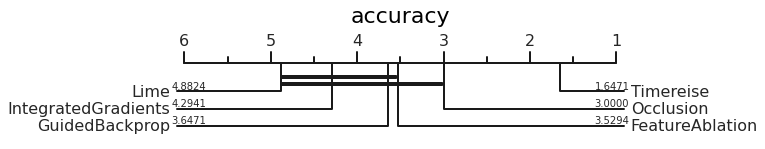

ins macro avg/f1-score
FeatureAblation         0.0
GuidedBackprop          1.0
IntegratedGradients     2.0
Lime                    0.0
Occlusion               1.0
Timereise              13.0
dtype: float64


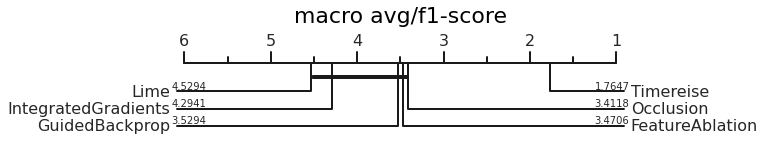

ins weighted avg/f1-score
FeatureAblation         0.0
GuidedBackprop          2.0
IntegratedGradients     1.0
Lime                    0.0
Occlusion               1.0
Timereise              13.0
dtype: float64


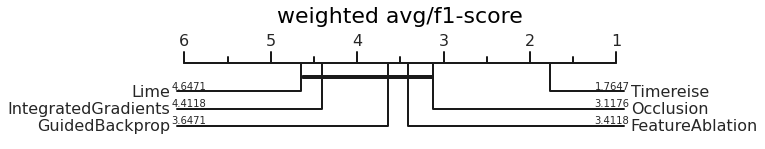

In [8]:
# auc
auc_files = get_files(root, exps, subsets, contains='AUC.pickle')
res_dict = get_res_dict(auc_files)
create_critical_auc(root, res_dict)

In [9]:
create_auc_table(res_dict)

                         & FeatureAblation & GuidedBackprop & IntegratedGradients & Lime & Occlusion & Timereise \\
                         & del    & ins    & del    & ins    & del    & ins    & del    & ins    & del    & ins    & del    & ins    \\
Anomaly                  & 0.7731 & 0.9737 & 0.7791 & 0.9597 & 0.7786 & 0.9624 & 0.7783 & 0.9473 & 0.7714 & 0.9739 & 0.7631 & 0.9867 \\
AsphaltPavementType      & 0.4073 & 0.8819 & 0.3930 & 0.8944 & 0.3940 & 0.8935 & 0.4622 & 0.8623 & 0.4171 & 0.8726 & 0.4135 & 0.8641 \\
AsphaltRegularity        & 0.5857 & 0.9954 & 0.5785 & 0.9960 & 0.5817 & 0.9964 & 0.6843 & 0.9871 & 0.5901 & 0.9929 & 0.5927 & 0.9833 \\
CharacterTrajectories    & 0.0856 & 0.8563 & 0.0807 & 0.8701 & 0.1091 & 0.8580 & 0.0785 & 0.8543 & 0.0878 & 0.8609 & 0.0401 & 0.8809 \\
Crop                     & 0.0998 & 0.3780 & 0.1402 & 0.3026 & 0.1404 & 0.2652 & 0.1096 & 0.3198 & 0.1583 & 0.3170 & 0.0628 & 0.5065 \\
ECG5000                  & 0.2104 & 0.8771 & 0.1876 & 0.8782 & 0.120

In [10]:
# create critical diagram compatible dataframe
def create_critical_generic(root, res_dict, metric):
    method = list(res_dict[list(res_dict)[0]]['summary'])[0]
    for mean_std in res_dict[list(res_dict)[0]]['summary'][method]:
        data = []
        print(mean_std)
        for dataset in res_dict:
            part_dict = res_dict[dataset]['summary']
            for method, score in part_dict.items():
                score = 1 - score[mean_std]
                data.append([method, dataset, score])
        frame = pd.DataFrame(data, columns=['classifier_name', 'dataset_name', 'accuracy'])
        fname = os.path.join(root, 'paper_figures', 'CDD_' + metric + '_' + mean_std + '.png')
        draw_cd_diagram(df_perf=frame, title=mean_std, labels=True, save_path=fname)
        
# create generic table
def create_generic_table(res_dict, use_std=False):
    max_len = max([len(d) for d in res_dict])
    res_str = ' ' * max_len
    for method in sorted(res_dict['Crop']['summary']):
        res_str = res_str + ' & ' + method
    res_str += ' \\\\'
    res_str = res_str + ' ' * max_len
    for method in sorted(res_dict['Crop']['summary']):
        res_str = res_str + ' & mean  '
        if use_std:
            res_str = res_str + ' & std   '
    res_str += ' \\\\'
    factor = 2 if use_std else 1
    averages = np.zeros(factor * len(list(res_dict['Crop']['summary'])))
    for dataset in sorted(res_dict):
        res_str = res_str + dataset + ' ' * (max_len - len(dataset))
        for idx, method in enumerate(sorted(res_dict[dataset]['summary'])):
            mean = res_dict[dataset]['summary'][method]['mean']
            res_str = res_str  + ' & '+ '{:.4f}'.format(mean)
            averages[factor * idx] += mean
            if use_std:
                std = res_dict[dataset]['summary'][method]['std']
                res_str = res_str  + ' & '+ '{:.4f}'.format(std)
                averages[factor * idx + 1] += std
        res_str += ' \\\\'
    averages /= len(list(res_dict))
    res_str = res_str + 'Average' + ' ' * (max_len - len('Average'))
    for avg in averages:
        res_str = res_str  + ' & '+ '{:.4f}'.format(avg)
    res_str += ' \\\\'
    
    print(res_str.replace('\\\\', '\\\\\n'))

In [11]:
# infidelity
inf_files = get_files(root, exps, subsets, contains='Infidelity_0.1_1000.pickle')
res_dict = get_res_dict(inf_files)
create_critical_generic(root, res_dict, 'Infidelity')

mean
the null hypothesis over the entire classifiers cannot be rejected
FeatureAblation        1.0
GuidedBackprop         3.0
IntegratedGradients    4.0
Lime                   3.0
Occlusion              1.0
Timereise              5.0
dtype: float64
std
the null hypothesis over the entire classifiers cannot be rejected
FeatureAblation        3.0
GuidedBackprop         2.0
IntegratedGradients    3.0
Lime                   4.0
Occlusion              2.0
Timereise              3.0
dtype: float64


In [12]:
# infidelity
create_generic_table(res_dict)

                         & FeatureAblation & GuidedBackprop & IntegratedGradients & Lime & Occlusion & Timereise \\
                         & mean   & mean   & mean   & mean   & mean   & mean   \\
Anomaly                  & 0.0233 & 0.0193 & 0.0158 & 0.0184 & 0.0222 & 0.0230 \\
AsphaltPavementType      & 0.2126 & 0.2126 & 0.2126 & 0.2127 & 0.2126 & 0.2124 \\
AsphaltRegularity        & 0.0045 & 0.0046 & 0.0046 & 0.0046 & 0.0045 & 0.0045 \\
CharacterTrajectories    & 0.1399 & 0.1397 & 0.1399 & 0.1399 & 0.1399 & 0.1396 \\
Crop                     & 0.2967 & 0.3081 & 0.3055 & 0.2966 & 0.3143 & 0.3032 \\
ECG5000                  & 0.0273 & 0.0272 & 0.0257 & 0.0210 & 0.0236 & 0.0242 \\
ElectricDevices          & 18.0869 & 18.1047 & 18.1130 & 18.1042 & 18.0854 & 18.1070 \\
FaceDetection            & 0.0002 & 0.0002 & 0.0002 & 0.0002 & 0.0002 & 0.0002 \\
FordA                    & 0.0118 & 0.0118 & 0.0116 & 0.0116 & 0.0118 & 0.0118 \\
HandOutlines             & 1.6914 & 1.7015 & 1.6932 & 1.69

mean
FeatureAblation         1.0
GuidedBackprop          0.0
IntegratedGradients     0.0
Lime                    0.0
Occlusion               6.0
Timereise              10.0
dtype: float64


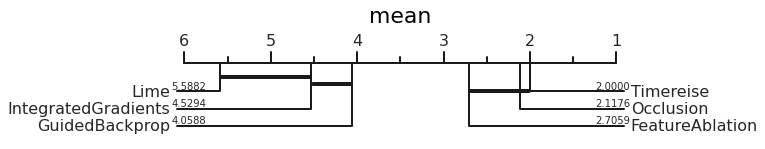

std
FeatureAblation         0.0
GuidedBackprop          0.0
IntegratedGradients     0.0
Lime                    0.0
Occlusion               1.0
Timereise              16.0
dtype: float64


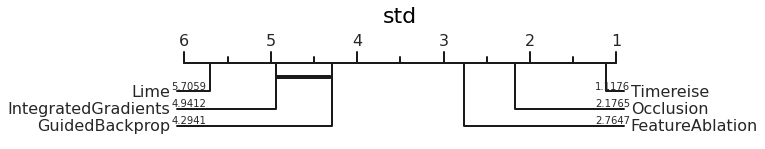

In [13]:
# sensitivity
sens_files = get_files(root, exps, subsets, contains='Sensitivity_0.05_10.pickle')
res_dict = get_res_dict(sens_files)
create_critical_generic(root, res_dict, 'Sensitivity')        

In [14]:
# sensitivity
create_generic_table(res_dict)

                         & FeatureAblation & GuidedBackprop & IntegratedGradients & Lime & Occlusion & Timereise \\
                         & mean   & mean   & mean   & mean   & mean   & mean   \\
Anomaly                  & 0.0574 & 0.0747 & 0.1470 & 0.2591 & 0.0664 & 0.0522 \\
AsphaltPavementType      & 0.0292 & 0.2864 & 0.0358 & 0.4259 & 0.0274 & 0.0705 \\
AsphaltRegularity        & 0.0288 & 0.2797 & 0.0567 & 0.3664 & 0.0274 & 0.0028 \\
CharacterTrajectories    & 0.0199 & 0.0547 & 0.0705 & 0.1353 & 0.0174 & 0.0076 \\
Crop                     & 0.0808 & 0.1060 & 0.1702 & 0.1786 & 0.1307 & 0.0411 \\
ECG5000                  & 0.0301 & 0.0772 & 0.1218 & 0.1811 & 0.0248 & 0.0111 \\
ElectricDevices          & 0.2069 & 0.2608 & 0.6129 & 0.2622 & 0.1949 & 0.1696 \\
FaceDetection            & 0.0180 & 0.0204 & 0.0136 & 0.4722 & 0.0144 & 0.0048 \\
FordA                    & 0.0231 & 0.0384 & 0.0708 & 0.1690 & 0.0155 & 0.0147 \\
HandOutlines             & 0.0952 & 0.1545 & 0.1203 & 0.1249 & 0

mean
FeatureAblation         0.0
GuidedBackprop          0.0
IntegratedGradients     0.0
Lime                    0.0
Occlusion               0.0
Timereise              17.0
dtype: float64


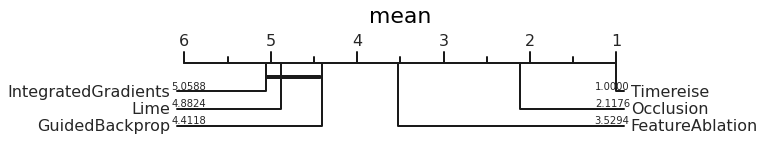

std
FeatureAblation         0.0
GuidedBackprop          0.0
IntegratedGradients     0.0
Lime                    1.0
Occlusion               0.0
Timereise              16.0
dtype: float64


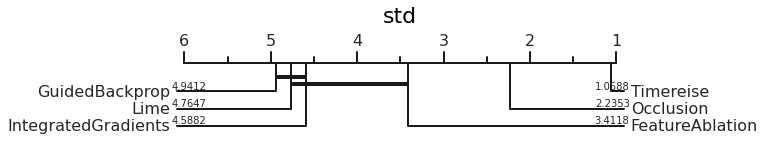

In [15]:
# continuity
con_files = get_files(root, exps, subsets, contains='Continuity.pickle')
res_dict = get_res_dict(con_files)
create_critical_generic(root, res_dict, 'Continuity')

In [16]:
# continuity
create_generic_table(res_dict)

                         & FeatureAblation & GuidedBackprop & IntegratedGradients & Lime & Occlusion & Timereise \\
                         & mean   & mean   & mean   & mean   & mean   & mean   \\
Anomaly                  & 0.1163 & 0.1444 & 0.1309 & 0.1390 & 0.0908 & 0.0473 \\
AsphaltPavementType      & 0.0792 & 0.0977 & 0.0770 & 0.0765 & 0.0450 & 0.0015 \\
AsphaltRegularity        & 0.0582 & 0.0703 & 0.0485 & 0.0525 & 0.0334 & 0.0008 \\
CharacterTrajectories    & 0.0264 & 0.0324 & 0.0368 & 0.0619 & 0.0243 & 0.0134 \\
Crop                     & 0.1282 & 0.1655 & 0.1952 & 0.1741 & 0.0985 & 0.0618 \\
ECG5000                  & 0.0682 & 0.1000 & 0.1004 & 0.0844 & 0.0505 & 0.0296 \\
ElectricDevices          & 0.2016 & 0.1840 & 0.1984 & 0.1950 & 0.0884 & 0.0350 \\
FaceDetection            & 0.0690 & 0.0745 & 0.0613 & 0.0331 & 0.0373 & 0.0161 \\
FordA                    & 0.0770 & 0.0819 & 0.0959 & 0.1530 & 0.0576 & 0.0083 \\
HandOutlines             & 0.0123 & 0.0183 & 0.0258 & 0.1501 & 0